<a href="https://colab.research.google.com/github/galievaz/bike-sharing-project/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.6 MB/s eta 0:00:00
  Preparing metadata (setup.py

In [3]:
!pip install kaggle

In [4]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
import json
kaggle_username = "dulic11221"
kaggle_key = "0a2244ded4f31a255a918ba1a934143b"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [6]:
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 66.7MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [68]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('./train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [69]:
features=['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']
target=['count']
train=train[list(features+target)]

In [71]:
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')

In [72]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

In [13]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


In [73]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('./test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [74]:
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S')

In [75]:
# Same thing as train and test dataset
submission = pd.read_csv('./sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [76]:
submission['datetime'] = pd.to_datetime(submission['datetime'], format='%Y-%m-%d %H:%M:%S')

# Step 3: Train a model using AutoGluon’s Tabular **Prediction**

In [18]:
predictor = TabularPredictor(label="count").fit(
    train_data=train,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220421_062940/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220421_062940/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11977.85 MB
	Train Data (Original)  Memory Usage: 0.

# **Review AutoGluon's training run with ranking of models that did the best.**

In [19]:
#predictor = TabularPredictor.load('AutogluonModels/ag-20220419_084331')
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.872357      12.165822  509.170966                0.000949           0.353125            3       True         15
1   RandomForestMSE_BAG_L2  -53.532914      11.196769  409.871496                0.593085          29.375683            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.788303      11.240796  389.046836                0.637111           8.551023            2       True         14
3          LightGBM_BAG_L2  -55.168528      10.848618  403.439229                0.244934          22.943415            2       True         11
4          CatBoost_BAG_L2  -55.459158      10.689743  447.947721                0.086059          67.451907            2       True         13
5        LightGBMXT_BAG_L2  -60.325352      14.195642  436.419375         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -52.872357      12.165822  509.170966   
 1   RandomForestMSE_BAG_L2  -53.532914      11.196769  409.871496   
 2     ExtraTreesMSE_BAG_L2  -53.788303      11.240796  389.046836   
 3          LightGBM_BAG_L2  -55.168528      10.848618  403.439229   
 4          CatBoost_BAG_L2  -55.459158      10.689743  447.947721   
 5        LightGBMXT_BAG_L2  -60.325352      14.195642  436.419375   
 6    KNeighborsDist_BAG_L1  -84.125061       0.104729    0.052161   
 7      WeightedEnsemble_L2  -84.125061       0.105880    0.880402   
 8    KNeighborsUnif_BAG_L1 -101.546199       0.103849    0.039059   
 9   RandomForestMSE_BAG_L1 -116.621736       0.568742   11.434054   
 10    ExtraTreesMSE_BAG_L1 -124.637158       0.498921    4.851758   
 11         CatBoost_BAG_L1 -130.551023       0.142859  205.358444   
 12         LightGBM_BAG_L1 -131.054162       1.535178   28.546594   
 13  

In [20]:
predictor.feature_importance(train)

Computing feature importance via permutation shuffling for 9 features using 1000 rows with 3 shuffle sets...
	245.69s	= Expected runtime (81.9s per shuffle set)
	129.69s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
datetime,189.402943,1.084479,0.000005,3,195.617127,183.188759
holiday,0.027956,0.026710,0.105770,3,0.181010,-0.125097
season,-0.507415,0.082015,0.995702,3,-0.037459,-0.977371
weather,-0.896282,0.327806,0.979094,3,0.982083,-2.774646
workingday,-2.046662,0.720212,0.980557,3,2.080235,-6.173559
windspeed,-2.679491,0.589827,0.992115,3,0.700281,-6.059262
temp,-2.957881,0.338781,0.997828,3,-1.016627,-4.899135
atemp,-3.197095,0.130850,0.999721,3,-2.447310,-3.946881
humidity,-3.396169,0.401654,0.997685,3,-1.094645,-5.697694


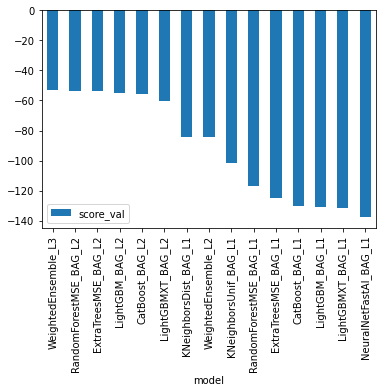

In [21]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

# Create predictions from test dataset

In [22]:
predictions = predictor.predict(test)
predictions.head()

0    24.548332
1    42.170288
2    47.281723
3    49.367546
4    52.461006
Name: count, dtype: float32

In [23]:
#NOTE: Kaggle will reject the submission if we don't set everything to be > 0.
# How many negative values do we have?
any(predictions<0)

False

# Set predictions to submission dataframe, save, and submit

In [24]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [25]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 793kB/s]
Successfully submitted to Bike Sharing Demand

View submission via the command line or in the web browser under the competition's page - My Submissions

In [26]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission.csv                                    2022-04-21 06:52:34  first raw submission                complete  1.79977      1.79977       
submission_new_hpo.csv                            2022-04-20 10:15:18  new features with hyperparameters3  complete  0.67256      0.67256       
submission.csv                                    2022-04-20 07:50:31  first raw submission                complete  1.81092      1.81092       
submission_new_hpo.csv                            2022-04-19 14:46:51  new features with hyperparameters3  complete  0.70365      0.70365       


Initial score of 1.79572

# **Step 4: Exploratory Data Analysis and Creating an additional feature**

Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.


In [77]:
# create a new feature
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


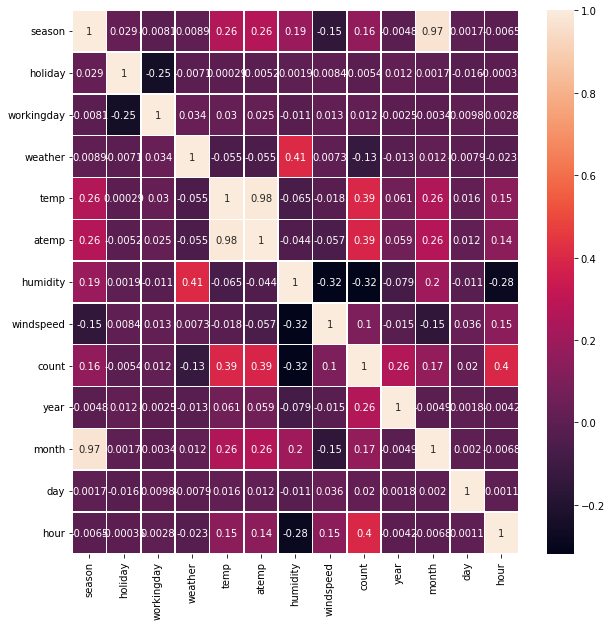

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
train_corr=train.drop('datetime', axis=1).corr()
sns.heatmap(train_corr, annot=True, linewidths=.5, ax=ax)

There are a high correlations between features "season" and "month" , "temp" and "atemp",  need to drop one of features in each pair. Let's choose season and temp

In [28]:
train=train.drop([ 'temp', 'month'], axis=1)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [29]:
test=test.drop([ 'temp', 'month'], axis=1)
test

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,year,day,hour
0,2011-01-20 00:00:00,1,0,1,1,11.365,56,26.0027,2011,20,0
1,2011-01-20 01:00:00,1,0,1,1,13.635,56,0.0000,2011,20,1
2,2011-01-20 02:00:00,1,0,1,1,13.635,56,0.0000,2011,20,2
3,2011-01-20 03:00:00,1,0,1,1,12.880,56,11.0014,2011,20,3
4,2011-01-20 04:00:00,1,0,1,1,12.880,56,11.0014,2011,20,4
...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,12.880,60,11.0014,2012,31,19
6489,2012-12-31 20:00:00,1,0,1,2,12.880,60,11.0014,2012,31,20
6490,2012-12-31 21:00:00,1,0,1,1,12.880,60,11.0014,2012,31,21
6491,2012-12-31 22:00:00,1,0,1,1,13.635,56,8.9981,2012,31,22


In [264]:
train.corr()

,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
holiday,1.000000,-0.250491,-0.007074,-0.005215,0.001929,0.008409,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.250491,1.000000,0.033772,0.024660,-0.010880,0.013373,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,-0.007074,0.033772,1.000000,-0.055376,0.406244,0.007261,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
atemp,-0.005215,0.024660,-0.055376,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.001929,-0.010880,0.406244,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,0.008409,0.013373,0.007261,-0.057473,-0.318607,1.000000,0.101369,-0.015221,-0.150192,0.036157,0.146631
count,-0.005393,0.011594,-0.128655,0.389784,-0.317371,0.101369,1.000000,0.260403,0.166862,0.019826,0.400601
year,0.012021,-0.002482,-0.012548,0.058540,-0.078606,-0.015221,0.260403,1.000000,-0.004932,0.001800,-0.004234
month,0.001731,-0.003394,0.012144,0.264173,0.204537,-0.150192,0.166862,-0.004932,1.000000,0.001974,-0.006818
day,-0.015877,0.009829,-0.007890,0.011866,-0.011335,0.036157,0.019826,0.001800,0.001974,1.000000,0.001132


In [291]:
# Consider new feature weekend
# selecting rows based on condition
rslt_df = train[(train['workingday'] == 0) &
          (train['holiday']==0)]
  
print('\nResult dataframe :\n', rslt_df)


Result dataframe :
                  datetime  holiday  workingday  weather   atemp  humidity  \
0     2011-01-01 00:00:00        0           0        1  14.395        81   
1     2011-01-01 01:00:00        0           0        1  13.635        80   
2     2011-01-01 02:00:00        0           0        1  13.635        80   
3     2011-01-01 03:00:00        0           0        1  14.395        75   
4     2011-01-01 04:00:00        0           0        1  14.395        75   
...                   ...      ...         ...      ...     ...       ...   
10809 2012-12-16 19:00:00        0           0        1  17.425        93   
10810 2012-12-16 20:00:00        0           0        2  19.695        82   
10811 2012-12-16 21:00:00        0           0        2  18.940        93   
10812 2012-12-16 22:00:00        0           0        2  20.455        82   
10813 2012-12-16 23:00:00        0           0        2  17.425        93   

       windspeed  count  year  month  day  hour  
0   

In [181]:
import numpy as np
train['weekend']=np.where((train['workingday']==0) & (train['holiday']==0), 1,0)
test['weekend']=np.where((test['workingday']==0) & (test['holiday']==0), 1,0)
train

,datetime,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour,weekend
0,2011-01-01 00:00:00,0,0,1,14.395,81,0.0000,16,2011,1,1,0,1
1,2011-01-01 01:00:00,0,0,1,13.635,80,0.0000,40,2011,1,1,1,1
2,2011-01-01 02:00:00,0,0,1,13.635,80,0.0000,32,2011,1,1,2,1
3,2011-01-01 03:00:00,0,0,1,14.395,75,0.0000,13,2011,1,1,3,1
4,2011-01-01 04:00:00,0,0,1,14.395,75,0.0000,1,2011,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,19.695,50,26.0027,336,2012,12,19,19,0
10882,2012-12-19 20:00:00,0,1,1,17.425,57,15.0013,241,2012,12,19,20,0
10883,2012-12-19 21:00:00,0,1,1,15.910,61,15.0013,168,2012,12,19,21,0
10884,2012-12-19 22:00:00,0,1,1,17.425,61,6.0032,129,2012,12,19,22,0


In [194]:
test

,datetime,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour,weekend
0,2011-01-20 00:00:00,0,1,1,11.365,56,26.0027,2011,1,20,0,0
1,2011-01-20 01:00:00,0,1,1,13.635,56,0.0000,2011,1,20,1,0
2,2011-01-20 02:00:00,0,1,1,13.635,56,0.0000,2011,1,20,2,0
3,2011-01-20 03:00:00,0,1,1,12.880,56,11.0014,2011,1,20,3,0
4,2011-01-20 04:00:00,0,1,1,12.880,56,11.0014,2011,1,20,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,0,1,2,12.880,60,11.0014,2012,12,31,19,0
6489,2012-12-31 20:00:00,0,1,2,12.880,60,11.0014,2012,12,31,20,0
6490,2012-12-31 21:00:00,0,1,1,12.880,60,11.0014,2012,12,31,21,0
6491,2012-12-31 22:00:00,0,1,1,13.635,56,8.9981,2012,12,31,22,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2ff0b8910>,
      dtype=object)

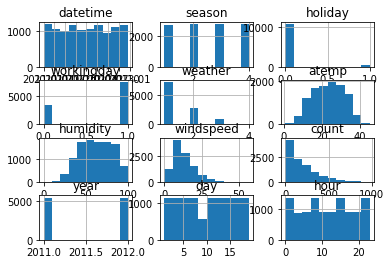

In [30]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [197]:
train.describe()

,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour,weekend
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,1.418427,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,11.541613,0.290557
std,0.166599,0.466159,0.633839,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,6.915838,0.454040
min,0.000000,0.000000,1.000000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000,0.000000
50%,0.000000,1.000000,1.000000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,12.000000,0.000000
75%,0.000000,1.000000,2.000000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,18.000000,1.000000
max,1.000000,1.000000,4.000000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,23.000000,1.000000


# **Make category types for these so models know they are not just numbers**



*   AutoGluon originally sees these as ints, but in reality they are int representations of a category.

*   Setting the dtype to category will classify these as categories in AutoGluon.



In [37]:
train.columns

Index(['datetime', 'holiday', 'workingday', 'weather', 'atemp', 'humidity',
       'windspeed', 'count', 'year', 'month', 'day', 'hour'],
      dtype='object')

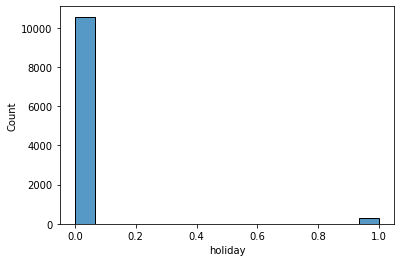

In [41]:
sns.histplot(train['holiday'])

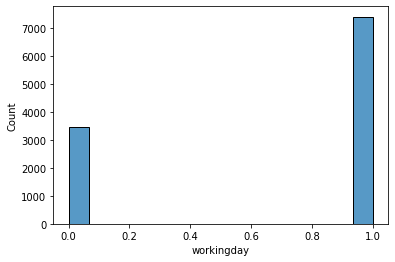

In [42]:
sns.histplot(train['workingday'])

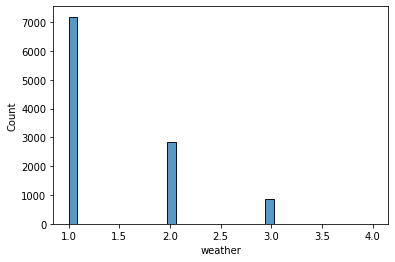

In [45]:
sns.histplot(train['weather'])

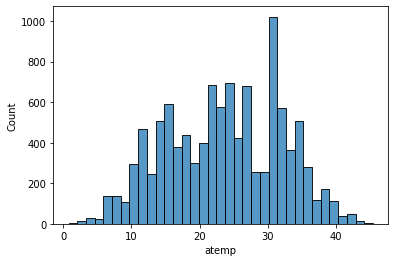

In [43]:
sns.histplot(train['atemp'])

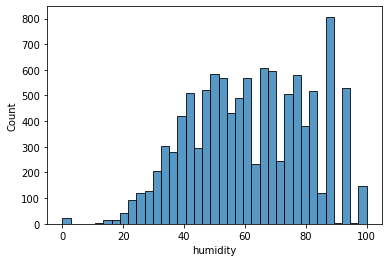

In [46]:
sns.histplot(train['humidity'])

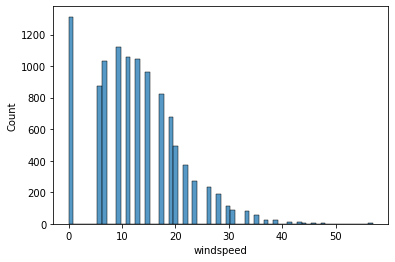

In [44]:
sns.histplot(train['windspeed'])

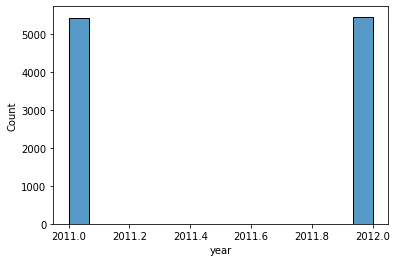

In [47]:
sns.histplot(train['year'])

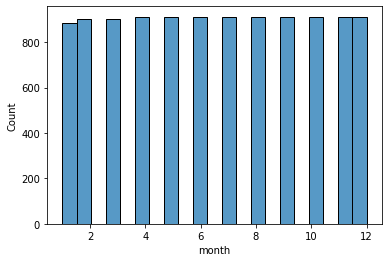

In [48]:
sns.histplot(train['month'])

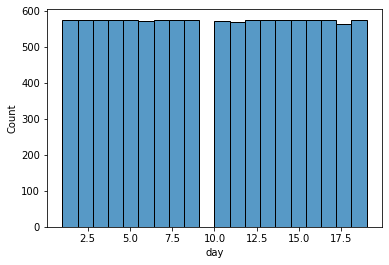

In [49]:
sns.histplot(train['day'])

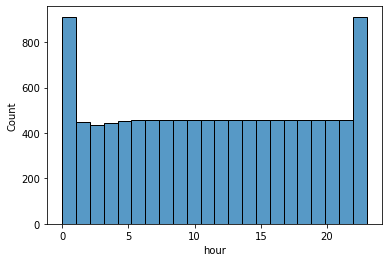

In [50]:
sns.histplot(train['hour'])

In [198]:
for each in train.columns:
    print('Feature', each, 'has county of unique values: ', train[each].nunique(), '( ', train[each].unique(),  ')\n with number of values for each unique: ', train[each].value_counts(), '\n')

Feature datetime has county of unique values:  10886 (  ['2011-01-01T00:00:00.000000000' '2011-01-01T01:00:00.000000000'
 '2011-01-01T02:00:00.000000000' ... '2012-12-19T21:00:00.000000000'
 '2012-12-19T22:00:00.000000000' '2012-12-19T23:00:00.000000000'] )
 with number of values for each unique:  2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: datetime, Length: 10886, dtype: int64 

Feature holiday has county of unique values:  2 (  [0 1] )
 with number of values for each unique:  0    10575
1      311
Name: holiday, dtype: int64 

Feature workingday has county of unique values:  2 (  [0 1] )
 with number of values for each unique:  1    7412
0    3474
Name: workingday, dtype: int64 

Feature weather has county of unique values:  4 (  [1 2 3 4] )
 with num

In [231]:
train['windspeed'].value_counts()

0.0        1313
8.9981     1120
11.0014    1057
12.998     1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
47.9988       2
56.9969       2
50.0021       1
51.9987       1
Name: windspeed, dtype: int64

In [233]:
train.dtypes

datetime           datetime64[ns]
holiday                      bool
workingday                   bool
weather                  category
atemp                     float64
humidity                    int64
windspeed                category
count                       int64
year                     category
month                    category
day                      category
hour                     category
weekend                      bool
part day                 category
level atemp                object
level humidity           category
level windspeed          category
dtype: object

In [31]:
def f(x):
    if (x > 7) and (x <= 9):
        return 'Early morning'
    elif (x > 9) and (x <= 11 ):
        return 'Morning'
    elif (x > 11) and (x <= 13):
        return'Lunch'
    elif (x > 13) and (x <= 17) :
        return 'Afternoon'
    elif (x > 17) and (x <= 21):
        return'Evening'
    elif (x > 21) or (x < 7):
        return'Late Night'
        
train['part day'] = train['hour'].apply(f)
test['part day'] = test['hour'].apply(f)

In [32]:
def f(x):
    if (x > 0) and (x <= 12):
        return 'Cold atemp'
    elif (x > 12) and (x <= 25 ):
        return 'Mild atemp'
    elif (x > 25):
        return 'Hot atemp'
train['level atemp'] = train['atemp'].apply(f)
test['level atemp'] = test['atemp'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,part day,level atemp
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,Late Night,Mild atemp
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,Late Night,Mild atemp
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,Late Night,Mild atemp
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,Late Night,Mild atemp
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,Late Night,Mild atemp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,Evening,Mild atemp
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,Evening,Mild atemp
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,Evening,Mild atemp
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,Late Night,Mild atemp


In [33]:
def f(x):
    if (x > 0) and (x <= 20 ):
        return 'Not humid'
    elif (x > 20) and (x <= 60 ):
        return 'Mild humid'
    elif (x > 60):
        return 'Very humid'
train['level humidity'] = train['humidity'].apply(f)
test['level humidity'] = test['humidity'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,part day,level atemp,level humidity
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,Late Night,Mild atemp,Very humid
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,Late Night,Mild atemp,Very humid
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,Late Night,Mild atemp,Very humid
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,Late Night,Mild atemp,Very humid
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,Late Night,Mild atemp,Very humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,Evening,Mild atemp,Mild humid
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,Evening,Mild atemp,Mild humid
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,Evening,Mild atemp,Very humid
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,Late Night,Mild atemp,Very humid


In [34]:
def f(x):
    if x == 0:
        return 'No wind'
    elif (x > 0) and (x <= 10 ):
        return 'Mild wind'
    elif (x > 10):
        return 'Very windy'
train['level windspeed'] = train['windspeed'].apply(f)
test['level windspeed'] = test['windspeed'].apply(f)
train

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,day,hour,part day,level atemp,level humidity,level windspeed
0,2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0000,16,2011,1,0,Late Night,Mild atemp,Very humid,No wind
1,2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0000,40,2011,1,1,Late Night,Mild atemp,Very humid,No wind
2,2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0000,32,2011,1,2,Late Night,Mild atemp,Very humid,No wind
3,2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0000,13,2011,1,3,Late Night,Mild atemp,Very humid,No wind
4,2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0000,1,2011,1,4,Late Night,Mild atemp,Very humid,No wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,19.695,50,26.0027,336,2012,19,19,Evening,Mild atemp,Mild humid,Very windy
10882,2012-12-19 20:00:00,4,0,1,1,17.425,57,15.0013,241,2012,19,20,Evening,Mild atemp,Mild humid,Very windy
10883,2012-12-19 21:00:00,4,0,1,1,15.910,61,15.0013,168,2012,19,21,Evening,Mild atemp,Very humid,Very windy
10884,2012-12-19 22:00:00,4,0,1,1,17.425,61,6.0032,129,2012,19,22,Late Night,Mild atemp,Very humid,Mild wind


In [298]:
boolean_columns=[ 'workingday', 'holiday']
for each in boolean_columns:
    train[each] = train[each].astype('bool')
    test[each] = test[each].astype('bool')

train.dtypes
test.dtypes

datetime           datetime64[ns]
holiday                      bool
workingday                   bool
weather                  category
atemp                     float64
humidity                    int64
windspeed                category
year                     category
month                    category
day                      category
hour                     category
part day                 category
level atemp              category
level humidity           category
level windspeed          category
dtype: object

In [80]:
#categorical_columns=[ 'windspeed',  'holiday', 'workingday', 'weather', 'year', 'season', 'day', 'hour',  'part day', 'level atemp', 'level humidity', 'level windspeed']
categorical_columns=[ 'windspeed',  'holiday', 'workingday', 'weather', 'year', 'season', 'day', 'hour', 'month']
for each in categorical_columns:
    train[each] = train[each].astype('category')
    test[each] = test[each].astype('category')

train.dtypes
test.dtypes


datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed           category
year                category
month               category
day                 category
hour                category
dtype: object

# **Step 5: Rerun the model with the same settings as before, just with more added features and dropped 'temp' and 'season'**

In [81]:
predictor_new_features =TabularPredictor(label="count").fit(
    train_data=train,
    time_limit=600,
    #presets="best_quality"
    auto_stack=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220421_112809/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220421_112809/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10821.79 MB
	Train Data (Original)  Memory Usage: 0.45 MB (0.0% of available memory)
	I

Let's distill AutoGluon’s predictor, which is most accurate ensemble-predictor into single models which are simpler/faster and require less memory/compute. Distillation can produce a model that is more accurate than the same model fit directly on the original training data

In [73]:
distilled_model_names = predictor_new_features.distill()

Distilling with teacher='WeightedEnsemble_L3', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 48985 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForest_DSTL', 'NeuralNetTorch_DSTL']
Fitting 5 L1 models ...
Fitting model: LightGBM_DSTL ...


[1000]	valid_set's rmse: 37.6346
[2000]	valid_set's rmse: 36.9902
[3000]	valid_set's rmse: 36.687
[4000]	valid_set's rmse: 36.5648
[5000]	valid_set's rmse: 36.4203
[6000]	valid_set's rmse: 36.3086
[7000]	valid_set's rmse: 36.2964
[8000]	valid_set's rmse: 36.268
[9000]	valid_set's rmse: 36.2424
[10000]	valid_set's rmse: 36.2045


	-36.2039	 = Validation score   (root_mean_squared_error)
	58.66s	 = Training   runtime
	1.74s	 = Validation runtime
Fitting model: NeuralNetMXNet_DSTL ...
		Starting in v0.5.0, calling TabularNeuralNetMxnetModel will raise an exception.
		Consider instead using TabularNeuralNetTorchModel via "NN_TORCH".
	-34.7379	 = Validation score   (root_mean_squared_error)
	1045.98s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: CatBoost_DSTL ...
	-36.5196	 = Validation score   (root_mean_squared_error)
	1371.32s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForest_DSTL ...
	-38.9828	 = Validation score   (root_mean_squared_error)
	107.94s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetTorch_DSTL ...
	-40.8945	 = Validation score   (root_mean_squared_error)
	187.11s	 = Training   runtime
	0.04s	 = Validation runtime
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']
Fitting model: WeightedEnsemble_L2_D

In [95]:
model_to_deploy = distilled_model_names[0]
predictions_nf=predictor_nf.predict(test, model=model_to_deploy)
predictions_nf

0         2.900478
1         4.329578
2         1.431616
3        -2.904552
4        -2.665607
           ...    
6488    330.659668
6489    195.279648
6490    146.437180
6491     83.125702
6492     39.210133
Name: count, Length: 6493, dtype: float32

In [94]:
model_to_deploy

'LightGBM_DSTL'

In [39]:
#predictor_nf = TabularPredictor.load("AutogluonModels/ag-20220419_092219/")
predictions_nf=predictor_new_features.predict(test)
predictions_nf

0        15.791378
1        14.640326
2        14.936869
3        11.856928
4         8.504492
           ...    
6488    269.212036
6489    199.547729
6490    170.089920
6491    125.139717
6492     91.866127
Name: count, Length: 6493, dtype: float32

In [40]:
#if predictions contain negative values
predictions_nf[predictions_nf < 0] = 0
predictions_nf

0        15.791378
1        14.640326
2        14.936869
3        11.856928
4         8.504492
           ...    
6488    269.212036
6489    199.547729
6490    170.089920
6491    125.139717
6492     91.866127
Name: count, Length: 6493, dtype: float32

In [85]:
predictor_new_features=predictor_nf.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -30.724358      13.696024   531.753327                0.001396           0.796456            3       True         14
1            LightGBM_BAG_L2  -31.074781      12.034514   430.348666                0.560841          30.399183            2       True         11
2          LightGBMXT_BAG_L2  -31.370434      12.729560   436.877059                1.255887          36.927576            2       True         10
3   WeightedEnsemble_L2_DSTL  -32.758467       2.530355  2584.121639                0.000594           0.223858            2       True         20
4            CatBoost_BAG_L2  -32.831449      11.877900   463.630113                0.404227          63.680630            2       True         13
5     RandomForestMSE_BAG_L2  -32.909024      12.200594 

In [41]:
submission["count"] = predictions_nf
submission.to_csv("submission_dropped_added_features.csv", index=False)

In [42]:
!kaggle competitions submit -c bike-sharing-demand -f submission_dropped_added_features.csv -m "new features2"

100% 188k/188k [00:00<00:00, 692kB/s]
Successfully submitted to Bike Sharing Demand

In [43]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_dropped_added_features.csv             2022-04-21 07:21:28  new features2                       complete  0.71431      0.71431       
submission.csv                                    2022-04-21 06:52:34  first raw submission                complete  1.79977      1.79977       
submission_new_hpo.csv                            2022-04-20 10:15:18  new features with hyperparameters3  complete  0.67256      0.67256       
submission.csv                                    2022-04-20 07:50:31  first raw submission                complete  1.81092      1.81092       


# New Score of ?

# **Step 6: Hyper parameter optimization**

In [62]:
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = ['auto' ] # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor_hpo = TabularPredictor(label='count').fit(
    train, time_limit=600,
    #auto_stack=True,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220421_093133/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220421_093133/"
AutoGluon Version:  0.4.0
Python Version:     3.7.13
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10530.48 MB
	Train Data (Original)  Memory Usage: 0.39 MB (0.0% of available memory)
	I

ValueError: ignored

In [52]:
predictor_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.277548      40.396847  558.796226                0.002060           0.519766            3       True         14
1          CatBoost_BAG_L2  -30.502471      38.409949  459.031752                0.092374          56.210436            2       True         13
2          LightGBM_BAG_L2  -30.677042      38.649904  432.166275                0.332329          29.344959            2       True         11
3        LightGBMXT_BAG_L2  -31.156009      39.121289  436.573785                0.803713          33.752469            2       True         10
4   RandomForestMSE_BAG_L2  -31.515528      39.166372  438.968596                0.848796          36.147280            2       True         12
5      WeightedEnsemble_L2  -31.915949      36.798875  359.938383         

{'leaderboard':                      model   score_val  pred_time_val    fit_time  \
 0      WeightedEnsemble_L3  -30.277548      40.396847  558.796226   
 1          CatBoost_BAG_L2  -30.502471      38.409949  459.031752   
 2          LightGBM_BAG_L2  -30.677042      38.649904  432.166275   
 3        LightGBMXT_BAG_L2  -31.156009      39.121289  436.573785   
 4   RandomForestMSE_BAG_L2  -31.515528      39.166372  438.968596   
 5      WeightedEnsemble_L2  -31.915949      36.798875  359.938383   
 6          LightGBM_BAG_L1  -33.505783       5.794332   65.409437   
 7          CatBoost_BAG_L1  -33.588879       0.145056  147.096895   
 8        LightGBMXT_BAG_L1  -34.642465      30.083694  128.401094   
 9     ExtraTreesMSE_BAG_L1  -37.780435       0.762904    6.603003   
 10  RandomForestMSE_BAG_L1  -38.347599       0.668595   17.877438   
 11   KNeighborsDist_BAG_L1  -84.125061       0.105532    0.059730   
 12   KNeighborsUnif_BAG_L1 -101.546199       0.105270    0.049186   
 13  

In [46]:
distilled_model_names = predictor_hpo.distill()

Distilling with teacher='WeightedEnsemble_L3', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 48985 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForest_DSTL', 'NeuralNetTorch_DSTL']
Fitting 5 L1 models ...
Fitting model: LightGBM_DSTL ...


[1000]	valid_set's rmse: 37.8704
[2000]	valid_set's rmse: 37.3518
[3000]	valid_set's rmse: 37.2125
[4000]	valid_set's rmse: 37.1037
[5000]	valid_set's rmse: 37.0375
[6000]	valid_set's rmse: 36.9543
[7000]	valid_set's rmse: 36.9602
[8000]	valid_set's rmse: 37.004


	-36.9269	 = Validation score   (root_mean_squared_error)
	51.76s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: NeuralNetMXNet_DSTL ...
		Starting in v0.5.0, calling TabularNeuralNetMxnetModel will raise an exception.
		Consider instead using TabularNeuralNetTorchModel via "NN_TORCH".
	-35.4666	 = Validation score   (root_mean_squared_error)
	1225.52s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: CatBoost_DSTL ...
	-37.921	 = Validation score   (root_mean_squared_error)
	1517.04s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: RandomForest_DSTL ...
	-42.426	 = Validation score   (root_mean_squared_error)
	115.17s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: NeuralNetTorch_DSTL ...
	-42.5792	 = Validation score   (root_mean_squared_error)
	156.6s	 = Training   runtime
	0.05s	 = Validation runtime
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']
Fitting model: WeightedEnsemble_L2_DSTL 

In [47]:
model_to_deploy = distilled_model_names[0]
predictions_hpo=predictor_hpo.predict(test, model=model_to_deploy)
predictions_hpo

0         8.245316
1        15.334908
2        11.716575
3         7.794611
4         7.051186
           ...    
6488    349.696503
6489    213.334106
6490    155.956284
6491    102.856850
6492     54.227161
Name: count, Length: 6493, dtype: float32

In [45]:
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_113702/")
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_115457/")
#predictor_hpo = TabularPredictor.load("AutogluonModels/ag-20220419_132403/")
predictions_hpo=predictor_hpo.predict(test)
predictions_hpo

0        16.372808
1        15.135984
2        16.098612
3        12.663477
4         8.943936
           ...    
6488    270.181427
6489    201.063477
6490    169.691650
6491    126.151428
6492     92.508110
Name: count, Length: 6493, dtype: float32

In [54]:
train

,datetime,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,0,0,1,14.395,81,0.0000,16,2011,1,1,0
1,2011-01-01 01:00:00,0,0,1,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,0,0,1,13.635,80,0.0000,32,2011,1,1,2
3,2011-01-01 03:00:00,0,0,1,14.395,75,0.0000,13,2011,1,1,3
4,2011-01-01 04:00:00,0,0,1,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,19.695,50,26.0027,336,2012,12,19,19
10882,2012-12-19 20:00:00,0,1,1,17.425,57,15.0013,241,2012,12,19,20
10883,2012-12-19 21:00:00,0,1,1,15.910,61,15.0013,168,2012,12,19,21
10884,2012-12-19 22:00:00,0,1,1,17.425,61,6.0032,129,2012,12,19,22


In [48]:
# Remember to set all negative values to zero
any(predictions_hpo<0)
#predictions

True

In [49]:
#set
predictions_hpo[predictions_hpo < 0] = 0
predictions_hpo


0         8.245316
1        15.334908
2        11.716575
3         7.794611
4         7.051186
           ...    
6488    349.696503
6489    213.334106
6490    155.956284
6491    102.856850
6492     54.227161
Name: count, Length: 6493, dtype: float32

In [50]:
# Same submitting predictions
submission["count"] = predictions_hpo
submission.to_csv("submission_new_hpo.csv", index=False)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters4"

100% 188k/188k [00:00<00:00, 611kB/s]
Successfully submitted to Bike Sharing Demand

In [53]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 10

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv                            2022-04-21 08:47:16  new features with hyperparameters4  complete  0.66675      0.66675       
submission_dropped_added_features.csv             2022-04-21 07:21:28  new features2                       complete  0.71431      0.71431       
submission.csv                                    2022-04-21 06:52:34  first raw submission                complete  1.79977      1.79977       
submission_new_hpo.csv                            2022-04-20 10:15:18  new features with hyperparameters3  complete  0.67256      0.67256       
submission.csv                                    2022-04-20 07:50:31  first raw submission                complete  1.81092      

In [54]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                                          date                 description                         status    publicScore  privateScore  
------------------------------------------------  -------------------  ----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv                            2022-04-21 08:47:16  new features with hyperparameters4  complete  0.66675      0.66675       
submission_dropped_added_features.csv             2022-04-21 07:21:28  new features2                       complete  0.71431      0.71431       
submission.csv                                    2022-04-21 06:52:34  first raw submission                complete  1.79977      1.79977       
submission_new_hpo.csv                            2022-04-20 10:15:18  new features with hyperparameters3  complete  0.67256      0.67256       
submission.csv                                    2022-04-20 07:50:31  first raw submission                complete  1.81092      

# New Score of 0.66675

# **# Step 7: Write a Report**
# Refer to the markdown file for the full report
# Creating plots and table for report

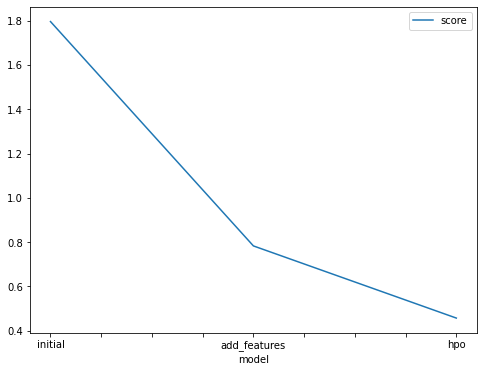

In [120]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [1.79572 ,  0.78285, 0.45708]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

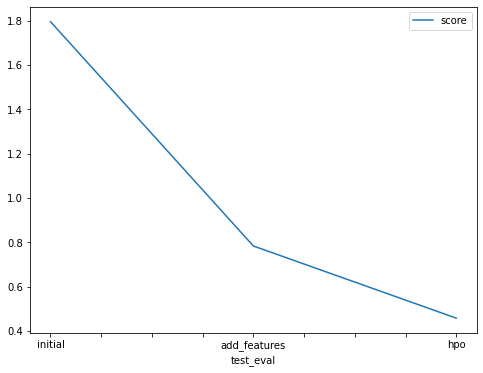

In [121]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79572 ,  0.78285, 0.45708]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

# **Hyperparameter table**

In [63]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "Time Limit": [700, 700, 700],
    "Architecture Used": ["Default", "Default", "NN or GBM"],
    "Training Data": ["Standard", "New Features Added", "New Features Added"],
    "score": [1.79572 ,  0.78285, 0.45708]
})

,model,Time Limit,Architecture Used,Training Data,score
0,initial,700,Default,Standard,1.79572
1,add_features,700,Default,New Features Added,0.78285
2,hpo,700,NN or GBM,New Features Added,0.45708
